<a href="https://colab.research.google.com/github/adnanmd-4567/kidney_stone_detection/blob/main/kidney_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("orvile/axial-ct-imaging-dataset-kidney-stone-detection")

print("Path to dataset files:", path)

100%|██████████| 3.78G/3.78G [00:41<00:00, 99.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/orvile/axial-ct-imaging-dataset-kidney-stone-detection/versions/2


In [ ]:
import os

In [ ]:
print(os.listdir(path))

['Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research', 'dataset.csv']


In [ ]:
path

'/root/.cache/kagglehub/datasets/orvile/axial-ct-imaging-dataset-kidney-stone-detection/versions/2'

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "/root/.cache/kagglehub/datasets/orvile/axial-ct-imaging-dataset-kidney-stone-detection/versions/2/dataset.csv"
df = pd.read_csv(csv_path)

In [ ]:
df

,dataset_type,category,number_of_files
0,Original Dataset,Non-Stone,1787
1,Original Dataset,Stone,1577
2,Augmented Dataset,Non-Stone,18800
3,Augmented Dataset,Stone,16600


In [ ]:
path = '/root/.cache/kagglehub/datasets/orvile/axial-ct-imaging-dataset-kidney-stone-detection/versions/2/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Axial CT Imaging Dataset for AI-Powered Kidney Stone Detection A Resource for Deep Learning Research/Kindy Stone Dataset/Original Dataset'

In [ ]:
classes = os.listdir(path)

In [ ]:
def make_df(classes,base_dir):
    data = []
    for label in classes:
        folder_path = os.path.join(base_dir, label)
        for file in os.listdir(folder_path):
            if file.endswith(('jpg','png')):
                file_path = os.path.join(folder_path, file)
                data.append((file_path, label))

    df = pd.DataFrame(data, columns=['file_path', 'label'])
    return df

In [ ]:
df = make_df(classes, path)
print("Shape of stroke dataset is:" ,df.shape)

Shape of stroke dataset is: (3364, 2)


In [ ]:
df['label'].value_counts()

,count
label,
Non-Stone,1787
Stone,1577


In [ ]:
label_mapping = {
    'Non-Stone': 0,
    'Stone': 1
}

df['label'] = df['label'].map(label_mapping)

print(df.head())

                                           file_path  label
0  /root/.cache/kagglehub/datasets/orvile/axial-c...      1
1  /root/.cache/kagglehub/datasets/orvile/axial-c...      1
2  /root/.cache/kagglehub/datasets/orvile/axial-c...      1
3  /root/.cache/kagglehub/datasets/orvile/axial-c...      1
4  /root/.cache/kagglehub/datasets/orvile/axial-c...      1


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size = 0.3, random_state=42, stratify = df['label'])
test_df, valid_df = train_test_split(temp_df, test_size = 0.333, random_state = 42, stratify = temp_df['label'])

train_ratio = len(train_df) / len(df)
test_ratio = len(test_df) / len(df)
valid_ratio = len(valid_df) / len(df)

print(f"length of dataframe: {len(df)}")
print(f"Training set shapes: {len(train_df)} ({train_ratio:.2%})")
print(f"Validation set shapes: {len(valid_df)} ({valid_ratio:.2%})")
print(f"Testing set shapes: {len(test_df)} ({test_ratio:.2%})")

length of dataframe: 3364
Training set shapes: 2354 (69.98%)
Validation set shapes: 337 (10.02%)
Testing set shapes: 673 (20.01%)


In [ ]:
def calculate_binary_weights(df):
  class_counts = df['label'].value_counts().to_dict()
  total_count = sum(class_counts.values())
  class_weights = {label : total_count / count for label, count in class_counts.items()}
  return class_weights

class_weights = calculate_binary_weights(df)
print(class_weights)

{0: 1.8824846110800224, 1: 2.133164235890932}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = preprocess_input
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [ ]:
print(train_df['label'].unique())
print(train_df['label'].map(type).unique())


['1' '0']
[<class 'str'>]


In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = valid_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True
)

test_generator = valid_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'file_path',
    y_col = 'label',
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False
)

Found 2354 validated image filenames belonging to 2 classes.
Found 337 validated image filenames belonging to 2 classes.
Found 673 validated image filenames belonging to 2 classes.


In [ ]:
batch_images, batch_labels = next(train_generator)
print(batch_images.shape)  # (batch_size, 256, 256, 3)
print(batch_labels.shape)  # (batch_size, num_classes)
print(batch_labels[:5])

(32, 224, 224, 3)
(32,)
[1. 1. 0. 0. 0.]


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer = Adam(1e-4),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
#from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.metrics import AUC

In [ ]:
# model = Sequential()

In [ ]:
# model.add(Conv2D(256, (3,3),padding='same', activation='relu', input_shape=(224,224,1)))
# model.add(MaxPooling2D(2,2))

# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# model.add(Flatten(name='flatten_4'))

In [ ]:
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

In [ ]:
# model.add(Dense(1, activation='sigmoid'))

In [ ]:
# optimizer = RMSprop(learning_rate=1e-4)
# model.compile(
    # optimizer=optimizer,
    # loss='binary_crossentropy',
    # metrics=['accuracy',AUC(name='auc')]
# )

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:120]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [ ]:
print("model training")
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = valid_generator,
    callbacks=[checkpoint],
    verbose = 1
)

model training


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5278 - loss: 0.7539
Epoch 1: val_accuracy improved from -inf to 0.53116, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.5283 - loss: 0.7532 - val_accuracy: 0.5312 - val_loss: 0.8586
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.6613 - loss: 0.6181
Epoch 2: val_accuracy improved from 0.53116 to 0.54006, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 622ms/step - accuracy: 0.6615 - loss: 0.6178 - val_accuracy: 0.5401 - val_loss: 0.8217
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7055 - loss: 0.5611
Epoch 3: val_accuracy improved from 0.54006 to 0.55193, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 611ms/step - accuracy: 0.7059 - loss: 0.5609 - val_accuracy: 0.5519 - val_loss: 0.8195
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.7803 - loss: 0.4986
Epoch 4: val_accuracy improved from 0.55193 to 0.56973, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 610ms/step - accuracy: 0.7804 - loss: 0.4984 - val_accuracy: 0.5697 - val_loss: 0.8065
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8257 - loss: 0.4333
Epoch 5: val_accuracy improved from 0.56973 to 0.58457, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - accuracy: 0.8256 - loss: 0.4333 - val_accuracy: 0.5846 - val_loss: 0.7761
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8419 - loss: 0.3897
Epoch 6: val_accuracy improved from 0.58457 to 0.61424, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 612ms/step - accuracy: 0.8418 - loss: 0.3897 - val_accuracy: 0.6142 - val_loss: 0.7205
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8491 - loss: 0.3767
Epoch 7: val_accuracy improved from 0.61424 to 0.63205, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 593ms/step - accuracy: 0.8490 - loss: 0.3767 - val_accuracy: 0.6320 - val_loss: 0.7033
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8779 - loss: 0.3208
Epoch 8: val_accuracy improved from 0.63205 to 0.68843, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 593ms/step - accuracy: 0.8779 - loss: 0.3208 - val_accuracy: 0.6884 - val_loss: 0.5844
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8851 - loss: 0.3038
Epoch 9: val_accuracy improved from 0.68843 to 0.71513, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 635ms/step - accuracy: 0.8851 - loss: 0.3036 - val_accuracy: 0.7151 - val_loss: 0.5633
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.9051 - loss: 0.2618
Epoch 10: val_accuracy improved from 0.71513 to 0.76855, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 611ms/step - accuracy: 0.9051 - loss: 0.2618 - val_accuracy: 0.7685 - val_loss: 0.4937
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8910 - loss: 0.2713
Epoch 11: val_accuracy improved from 0.76855 to 0.79228, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 602ms/step - accuracy: 0.8911 - loss: 0.2712 - val_accuracy: 0.7923 - val_loss: 0.4473
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9205 - loss: 0.2198
Epoch 12: val_accuracy improved from 0.79228 to 0.82789, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 610ms/step - accuracy: 0.9203 - loss: 0.2200 - val_accuracy: 0.8279 - val_loss: 0.4008
Epoch 13/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9124 - loss: 0.2277
Epoch 13: val_accuracy did not improve from 0.82789
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - accuracy: 0.9124 - loss: 0.2276 - val_accuracy: 0.8279 - val_loss: 0.3849
Epoch 14/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9222 - loss: 0.2032
Epoch 14: val_accuracy improved from 0.82789 to 0.87537, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 612ms/step - accuracy: 0.9222 - loss: 0.2032 - val_accuracy: 0.8754 - val_loss: 0.3201
Epoch 15/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9334 - loss: 0.1837
Epoch 15: val_accuracy did not improve from 0.87537
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 594ms/step - accuracy: 0.9333 - loss: 0.1838 - val_accuracy: 0.8754 - val_loss: 0.3013
Epoch 16/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9173 - loss: 0.2016
Epoch 16: val_accuracy improved from 0.87537 to 0.89911, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 588ms/step - accuracy: 0.9174 - loss: 0.2015 - val_accuracy: 0.8991 - val_loss: 0.2876
Epoch 17/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9276 - loss: 0.1806
Epoch 17: val_accuracy did not improve from 0.89911
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 591ms/step - accuracy: 0.9277 - loss: 0.1805 - val_accuracy: 0.8902 - val_loss: 0.2720
Epoch 18/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9392 - loss: 0.1548
Epoch 18: val_accuracy improved from 0.89911 to 0.90208, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 586ms/step - accuracy: 0.9392 - loss: 0.1549 - val_accuracy: 0.9021 - val_loss: 0.2500
Epoch 19/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9351 - loss: 0.1683
Epoch 19: val_accuracy improved from 0.90208 to 0.90504, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 598ms/step - accuracy: 0.9352 - loss: 0.1683 - val_accuracy: 0.9050 - val_loss: 0.2487
Epoch 20/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9436 - loss: 0.1609
Epoch 20: val_accuracy improved from 0.90504 to 0.91098, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 600ms/step - accuracy: 0.9436 - loss: 0.1609 - val_accuracy: 0.9110 - val_loss: 0.2344
Epoch 21/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9466 - loss: 0.1477
Epoch 21: val_accuracy improved from 0.91098 to 0.92582, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 588ms/step - accuracy: 0.9466 - loss: 0.1476 - val_accuracy: 0.9258 - val_loss: 0.2060
Epoch 22/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9481 - loss: 0.1373
Epoch 22: val_accuracy did not improve from 0.92582
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 594ms/step - accuracy: 0.9481 - loss: 0.1374 - val_accuracy: 0.9110 - val_loss: 0.2119
Epoch 23/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9532 - loss: 0.1319
Epoch 23: val_accuracy did not improve from 0.92582
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 593ms/step - accuracy: 0.9532 - loss: 0.1319 - val_accuracy: 0.9228 - val_loss: 0.2108
Epoch 24/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9450 - loss: 0.1449
Epoch 24: val_accuracy improved from 0.92582 to 0.93175, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 611ms/step - accuracy: 0.9451 - loss: 0.1448 - val_accuracy: 0.9318 - val_loss: 0.1874
Epoch 25/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9449 - loss: 0.1474
Epoch 25: val_accuracy improved from 0.93175 to 0.93472, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 640ms/step - accuracy: 0.9450 - loss: 0.1472 - val_accuracy: 0.9347 - val_loss: 0.1679
Epoch 26/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.9496 - loss: 0.1351
Epoch 26: val_accuracy did not improve from 0.93472
74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 587ms/step - accuracy: 0.9497 - loss: 0.1350 - val_accuracy: 0.9347 - val_loss: 0.1618
Epoch 27/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9600 - loss: 0.1149
Epoch 27: val_accuracy did not improve from 0.93472
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - accuracy: 0.9599 - loss: 0.1150 - val_accuracy: 0.9347 - val_loss: 0.1673
Epoch 28/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9707 - loss: 0.0893
Epoch 28: val_accuracy improved from 0.93472 to 0.93769, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 43s 584ms/step - accuracy: 0.9707 - loss: 0.0895 - val_accuracy: 0.9377 - val_loss: 0.1543
Epoch 29/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9676 - loss: 0.1005
Epoch 29: val_accuracy improved from 0.93769 to 0.94065, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 588ms/step - accuracy: 0.9676 - loss: 0.1006 - val_accuracy: 0.9407 - val_loss: 0.1595
Epoch 30/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.9538 - loss: 0.1197
Epoch 30: val_accuracy improved from 0.94065 to 0.94362, saving model to best_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 608ms/step - accuracy: 0.9538 - loss: 0.1196 - val_accuracy: 0.9436 - val_loss: 0.1394


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model.save('final_model.keras')

In [ ]:
from sklearn.metrics import classification_report

y_test = test_generator.classes

y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)

target_names = list(test_generator.class_indices.keys())

print(classification_report(y_test, y_pred, target_names=['Normal', 'Stroke']))

22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 735ms/step
              precision    recall  f1-score   support

      Normal       0.90      0.99      0.94       358
      Stroke       0.99      0.87      0.93       315

    accuracy                           0.94       673
   macro avg       0.94      0.93      0.94       673
weighted avg       0.94      0.94      0.94       673



In [ ]:
results = model.evaluate(test_generator, verbose=1)

print(f"Test loss: {results[0]:.4f}")
print(f"Test accuracy: {results[1]:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9342 - loss: 0.1682
Test loss: 0.1753
Test accuracy: 0.9361


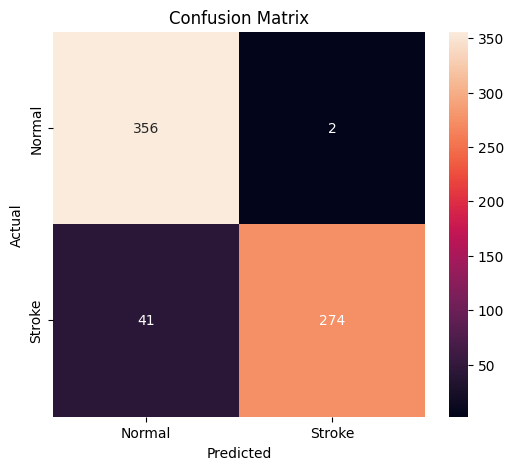

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'Stroke'], yticklabels=['Normal', 'Stroke'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step


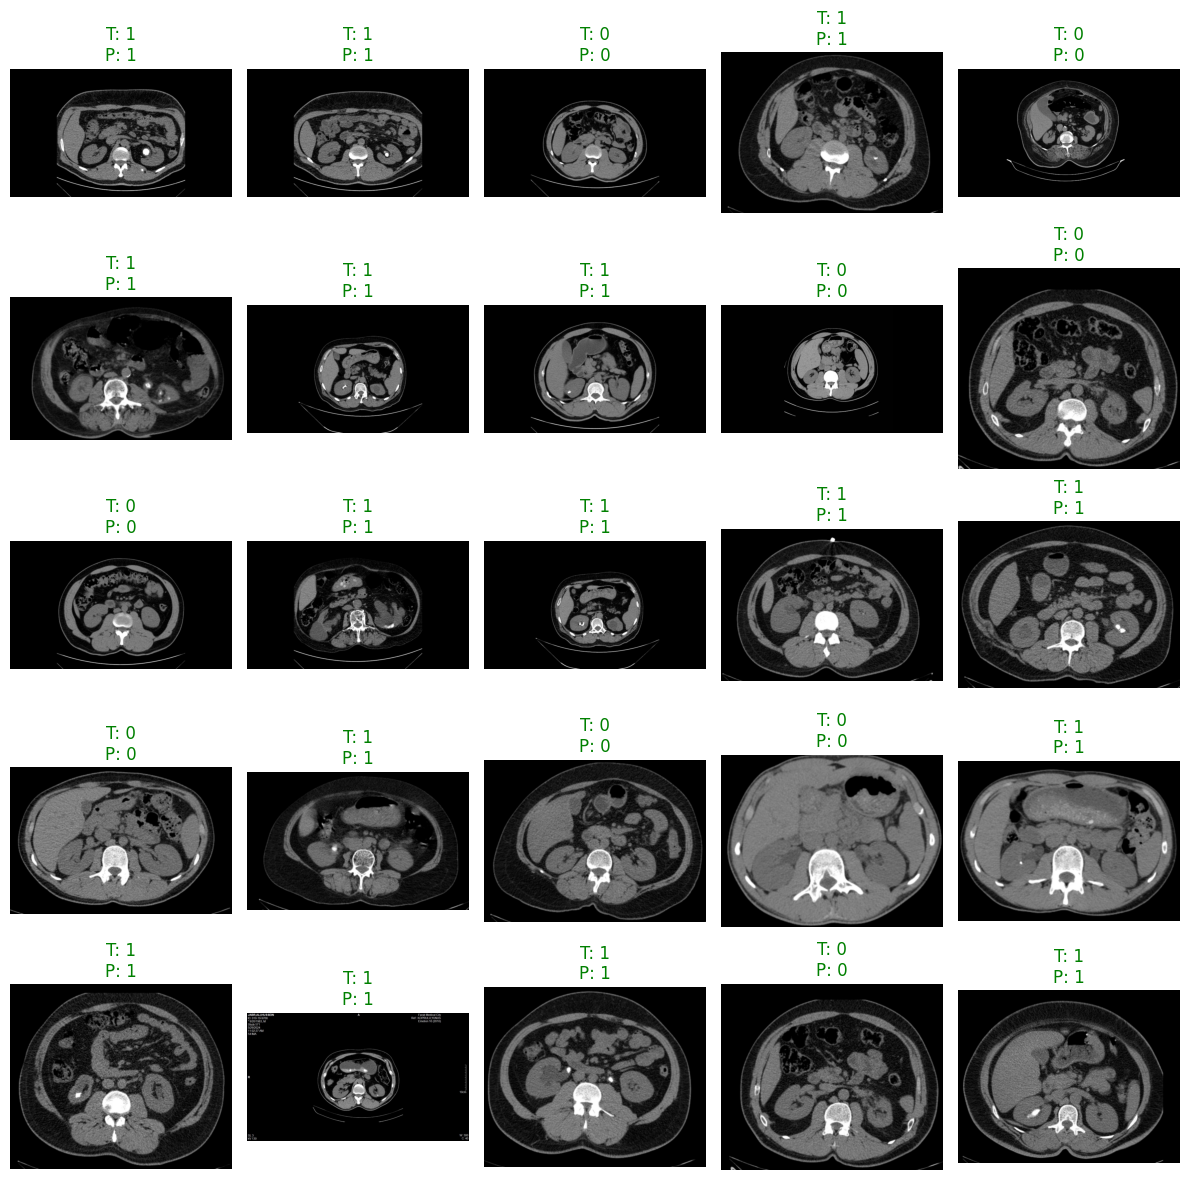

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_images = 25
indices = np.random.choice(len(test_generator.filenames), num_images, replace=False)

y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int).flatten()

rows = cols = int(np.ceil(np.sqrt(num_images)))
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    img = plt.imread(test_generator.filepaths[idx])
    true_label = y_true[idx]
    pred_label = y_pred[idx]

    ax.imshow(img, cmap="gray")
    ax.set_title(
        f"T: {class_names[true_label]}\nP: {class_names[pred_label]}",
        color="green" if true_label == pred_label else "red"
    )
    ax.axis("off")

for ax in axes[num_images:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
model.save("stroke_model.keras")

In [ ]:
from google.colab import files
files.download("stroke_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df

,file_path,label
0,/root/.cache/kagglehub/datasets/orvile/axial-c...,1
1,/root/.cache/kagglehub/datasets/orvile/axial-c...,1
2,/root/.cache/kagglehub/datasets/orvile/axial-c...,1
3,/root/.cache/kagglehub/datasets/orvile/axial-c...,1
4,/root/.cache/kagglehub/datasets/orvile/axial-c...,1
...,...,...
3359,/root/.cache/kagglehub/datasets/orvile/axial-c...,0
3360,/root/.cache/kagglehub/datasets/orvile/axial-c...,0
3361,/root/.cache/kagglehub/datasets/orvile/axial-c...,0
3362,/root/.cache/kagglehub/datasets/orvile/axial-c...,0


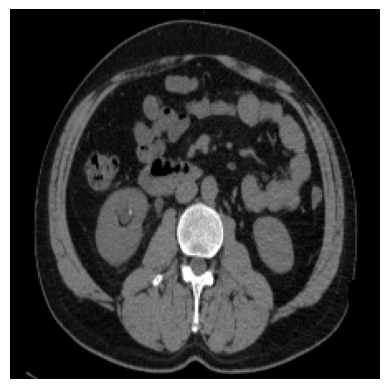

(224, 224, 3)

In [ ]:
my_img = cv.imread(df['file_path'][0], cv.IMREAD_COLOR)
my_img = cv.resize(my_img,(224,224))
plt.imshow(my_img)
plt.axis('off')
plt.show()
my_img.shape